In [ ]:
!nvidia-smi

Thu Nov 17 14:41:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

It is better to train all the model in the single notebook because it will save the time and power of creating dataloader

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid

import glob
import os
import json
import nibabel as nib

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!pip install albumentations==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 10.0 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=1600ab75127834baa8580646a1f394e51280547d6d9e3cf4d620d94ae174c708
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 376 kB 52.8 MB/s 
     |████████████████████████████████| 58 kB 6.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=bff914f0657de74ff21756c31e3f079fc671cea77fb3ab70a6bdd9e917476ba1
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=0e2c537d09a044b068a48e0acb75750969f7f0a1f32e4e96ce7f5320b6a60398
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2

from sklearn.model_selection import train_test_split

In [ ]:
from torchvision.models import resnext50_32x4d
import segmentation_models_pytorch as smp

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
def seed_all(seed = 13):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    print("Seed set to", seed)

seed_all()

Seed set to 13


## Prepare data

In [ ]:
import numpy as np
import os

    
def get_decathlon_filelist(data_path, seed=816, split=0.85):
    """
    Get the paths for the original decathlon files
    """
    json_filename = os.path.join(data_path, "dataset.json")

    try:
        with open(json_filename, "r") as fp:
            experiment_data = json.load(fp)
    except IOError as e:
        raise Exception("File {} doesn't exist. It should be part of the "
              "Decathlon directory".format(json_filename))

    # Print information about the Decathlon  data
    print("*" * 30)
    print("=" * 30)
    print("Dataset name:        ", experiment_data["name"])
    print("Dataset description: ", experiment_data["description"])
    print("Tensor image size:   ", experiment_data["tensorImageSize"])
    print("=" * 30)
    print("*" * 30)
    
    # Set the random seed so that always get same random mix
    np.random.seed(seed)
    numFiles = experiment_data["numTraining"]
    idxList = np.arange(numFiles)  # List of file indices
    np.random.shuffle(idxList) # Shuffle the indices to randomize train/test/split
    
    trainIdx = int(np.floor(numFiles*split)) # index for the end of the training files
    trainList = idxList[:trainIdx]

    otherList = idxList[trainIdx:]
    numOther = len(otherList)
    otherIdx = numOther//2  # index for the end of the testing files
    validateList = otherList[:otherIdx]
    testList = otherList[otherIdx:]

    trainFiles = []
    for idx in trainList:
        trainFiles.append(os.path.join(data_path, experiment_data["training"][idx]["label"]))

    validateFiles = []
    for idx in validateList:
        validateFiles.append(os.path.join(data_path, experiment_data["training"][idx]["label"]))

    testFiles = []
    for idx in testList:
        testFiles.append(os.path.join(data_path, experiment_data["training"][idx]["label"]))

    print("Number of training files   = {}".format(len(trainList)))
    print("Number of validation files = {}".format(len(validateList)))
    print("Number of testing files    = {}".format(len(testList)))

    return trainFiles, validateFiles, testFiles

In [ ]:
data_path = "/gdrive/My Drive/Kwork/Task05_Prostate"

train_files, valid_files, test_files = get_decathlon_filelist(data_path=data_path, seed=13, split=0.75)

def remove_bug(file_):
    f = []
    for x in file_:
      x = data_path + x
      f.append(x)
    return f

train_files = remove_bug(train_files)
valid_files = remove_bug(valid_files)
test_files = remove_bug(test_files)

******************************
Dataset name:         PROSTATE
Dataset description:  Prostate transitional zone and peripheral zone segmentation
Tensor image size:    4D
******************************
Number of training files   = 24
Number of validation files = 4
Number of testing files    = 4


## Dataset and Dataloader

In [ ]:
# Transformations 

PATCH_SIZE = 128

transforms = A.Compose([
    #A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.4),
    A.VerticalFlip(p=0.4),
    A.RandomRotate90(p=0.4),
    A.Transpose(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    #A.Normalize(p=1.0),
    ToTensor(),
])


In [ ]:
class MriDataset(Dataset):
    def __init__(self, f, transforms):
        
        self.f = f
        self.transforms = transforms
        
    def __len__(self):
        return len(self.f)
    
    def __getitem__(self, idx):
        label_filename = self.f[idx]
        img_filename   = label_filename.replace("labelsTr", "imagesTr")
        
        image = np.array(nib.load(img_filename).dataobj)
        slice_ = np.random.randint(0, image.shape[2])
        #image = image[:,:,slice_,0]  # Just take FLAIR channel (channel 0)
        image = image[:,:,:10,0]
        label = np.array(nib.load(label_filename).dataobj)
        
        #print(image.shape)
        label = np.expand_dims(label, axis=3)
        image = np.expand_dims(image, axis=-1)
        #print('1')
        #print(label.shape)
        # make transforms
        #label = label[:,:,slice_,:]
        label = label[:,:,:10,:]
        #print(image.shape, label.shape)

        image = image[:128, :128, :, :]
        label = label[:128, :128, :, :]
        '''
        augmented = self.transforms(image=image, 
                                    mask=label)
        image = augmented['image']
        label = augmented['mask']   
        '''
        
        return image, label   

In [ ]:
# train
train_dataset = MriDataset(f=train_files, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=3, num_workers=1, shuffle=True)

# val
val_dataset = MriDataset(f=valid_files, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=3, num_workers=1, shuffle=True)

#test
test_dataset = MriDataset(f=test_files, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=3, num_workers=1, shuffle=True)

## Model Utils

In [ ]:
# For vanilla UNet
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

In [ ]:
# For FPN
class ConvReluUpsample(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.make_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, (3, 3), stride=1, padding=1, bias=False
            ),
            nn.GroupNorm(32, out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        x = self.block(x)
        if self.upsample:
            x = self.make_upsample(x)
        return x


class SegmentationBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_upsamples=0):
        super().__init__()

        blocks = [ConvReluUpsample(in_channels, out_channels, upsample=bool(n_upsamples))]

        if n_upsamples > 1:
            for _ in range(1, n_upsamples):
                blocks.append(ConvReluUpsample(out_channels, out_channels, upsample=True))

        self.block = nn.Sequential(*blocks)

    def forward(self, x):
        return self.block(x)

In [ ]:
# For resnext backbone
class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)
        return x

## Models

In [ ]:
class Vanilla_UNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.model_name = "Vanila_UNet"
        self.conv_down1 = double_conv(1, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        self.conv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128)
        self.conv_up1 = double_conv(128 + 64, 64)
        self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
    def forward(self, x):
        conv1 = self.conv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.conv_down2(x)
        x = self.maxpool(conv2) 
        conv3 = self.conv_down3(x)
        x = self.maxpool(conv3)
        x = self.upsample(self.conv_down4(x))
        x = torch.cat([x, conv3], dim=1)
        x = self.upsample(self.conv_up3(x))
        x = torch.cat([x, conv2], dim=1) 
        x = self.upsample(self.conv_up2(x))
        x = self.conv_up1(torch.cat([x, conv1], dim=1))
        x = torch.sigmoid(self.last_conv(x))
        return x

In [ ]:
vanilla_unet = Vanilla_UNet(n_classes=1).to(device)
vanilla_unet

Vanilla_UNet(
  (conv_down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(k

In [ ]:
class ResNeXtUNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.model_name = "ResNeX_backbone_tUNet"
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512] # base model params
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
                       
    def forward(self, x):
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        x = torch.sigmoid(self.last_conv1(self.last_conv0(d1)))
        return x

In [ ]:
resnext_unet = ResNeXtUNet(n_classes=1).to(device)
resnext_unet

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNeXtUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample)

In [ ]:
class FPN_UNet(nn.Module):

    def __init__(self, n_classes=1, 
                 pyramid_channels=256, 
                 segmentation_channels=256):
        super().__init__()
        self.model_name = "FPN_UNet"
        self.conv_down1 = double_conv(1, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)        
        self.conv_down5 = double_conv(512, 1024)   
        self.maxpool = nn.MaxPool2d(2)
        self.toplayer = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.latlayer1 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
        self.seg_blocks = nn.ModuleList([
            SegmentationBlock(pyramid_channels, segmentation_channels, n_upsamples=n_upsamples)
            for n_upsamples in [0, 1, 2, 3]
        ])
        self.last_conv = nn.Conv2d(256, n_classes, kernel_size=1, stride=1, padding=0)
        
    def upsample_add(self, x, y):
        _,_,H,W = y.size()
        upsample = nn.Upsample(size=(H,W), mode='bilinear', align_corners=True) 
        return upsample(x) + y
    
    def upsample(self, x, h, w):
        sample = nn.Upsample(size=(h, w), mode='bilinear', align_corners=True)
        return sample(x)
        
    def forward(self, x):
        c1 = self.maxpool(self.conv_down1(x))
        c2 = self.maxpool(self.conv_down2(c1))
        c3 = self.maxpool(self.conv_down3(c2))
        c4 = self.maxpool(self.conv_down4(c3))
        c5 = self.maxpool(self.conv_down5(c4)) 

        p5 = self.toplayer(c5) 
        p4 = self.upsample_add(p5, self.latlayer1(c4)) # ???
        p3 = self.upsample_add(p4, self.latlayer2(c3))
        p2 = self.upsample_add(p3, self.latlayer3(c2)) 
        
        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)
        
        _, _, h, w = p2.size()
        feature_pyramid = [seg_block(p) for seg_block, p in zip(self.seg_blocks, [p2, p3, p4, p5])]
        
        x = torch.sigmoid(self.upsample(self.last_conv(sum(feature_pyramid)), 4 * h, 4 * w))
        return x

In [ ]:
fpn_unet = FPN_UNet().to(device)
fpn_unet

FPN_UNet(
  (conv_down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_down5): Sequential(


In [ ]:
# there is ready library for this
class FPN_Eff(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        self.model_name = "FPN_Eff"
        self.network = smp.FPN(
            encoder_name="efficientnet-b7",
            encoder_weights="imagenet",
            in_channels=1,
            classes=n_classes,
            activation='sigmoid',
    )
    def forward(self, x):
        return self.network(x)

In [ ]:
fpn_eff = FPN_Eff().to(device)
fpn_eff

FPN_Eff(
  (network): FPN(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        1, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            64, 16, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            16, 64, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identi

## Evaluation

In [ ]:
def iou(predictions, labels, e = 1e-7): # e is to avoid zeros
    predictions = torch.where(predictions > 0.5, 1, 0)
    labels = labels.byte()
    intersection = (predictions & labels).float().sum((1, 2))
    union = (predictions | labels).float().sum((1, 2))
    iou = (intersection + e) / (union + e)
    return iou

def dice(predictions, labels, e = 1e-7):
    predictions = torch.where(predictions > 0.5, 1, 0)
    labels = labels.byte()
    intersection = (predictions & labels).float().sum((1, 2))
    dice = ((2 * intersection) + e) / (predictions.float().sum((1, 2)) + labels.float().sum((1, 2)) + e)
    return dice

def dice_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

In [ ]:
'''
def compute_dice(model, loader, threshold=0.3):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    valloss = 0
    
    with torch.no_grad():
        for i_step, (data, target) in enumerate(loader):
            data = data.to(device)
            target = target.to(device)
            outputs = model(data)
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss / i_step
'''

'\ndef compute_dice(model, loader, threshold=0.3):\n    """\n    Computes accuracy on the dataset wrapped in a loader\n    \n    Returns: accuracy as a float value between 0 and 1\n    """\n    valloss = 0\n    \n    with torch.no_grad():\n        for i_step, (data, target) in enumerate(loader):\n            data = data.to(device)\n            target = target.to(device)\n            outputs = model(data)\n            out_cut = np.copy(outputs.data.cpu().numpy())\n            out_cut[np.nonzero(out_cut < threshold)] = 0.0\n            out_cut[np.nonzero(out_cut >= threshold)] = 1.0\n\n            picloss = dice_metric(out_cut, target.data.cpu().numpy())\n            valloss += picloss\n\n    return valloss / i_step\n'

In [ ]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    with torch.no_grad():
        for i_step, (data, target) in enumerate(loader):
            data = data.to(device)
            target = target.to(device)

            data = data.reshape(data.shape[0]*data.shape[3], data.shape[4], data.shape[1], data.shape[2])   
            target = target.reshape(target.shape[0]*target.shape[3], target.shape[4], target.shape[1], target.shape[2])  
            target = target.float()
                        
            outputs = model(data)
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0
            picloss = dice_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss
    if i_step == 0:
        i_step = 1 

    return valloss / i_step

## Train utils

In [ ]:
# made up loss to train the model

def dice_coef_loss(predictions, labels):
    intersection = 2.0 * ((labels * predictions).sum()) + 1.0
    union = labels.sum() + predictions.sum() + 1.0
    loss = 1 - (intersection / union)
    return loss


def bce_dice_loss(predictions, labels):
    dicescore = dice_coef_loss(predictions, labels)
    bcescore = nn.BCELoss()
    bceloss = bcescore(predictions, labels)
    loss = bceloss + dicescore
    return loss

In [ ]:
# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [ ]:
# Not effective
'''
class EarlyStopping():
raining when loss stops decreasing in a PyTorch module.
    """
    def __init__(self, patience:int = 6, min_delta: float = 0, weights_path: str = 'weights.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.weights_path = weights_path

    def __call__(self, val_loss: float, model: torch.nn.Module):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.weights_path)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def load_weights(self, model: torch.nn.Module):
        return model.load_state_dict(torch.load(self.weights_path))
'''

'\nclass EarlyStopping():\nraining when loss stops decreasing in a PyTorch module.\n    """\n    def __init__(self, patience:int = 6, min_delta: float = 0, weights_path: str = \'weights.pt\'):\n        self.patience = patience\n        self.min_delta = min_delta\n        self.counter = 0\n        self.best_loss = float(\'inf\')\n        self.weights_path = weights_path\n\n    def __call__(self, val_loss: float, model: torch.nn.Module):\n        if self.best_loss - val_loss > self.min_delta:\n            self.best_loss = val_loss\n            torch.save(model.state_dict(), self.weights_path)\n            self.counter = 0\n        else:\n            self.counter += 1\n            if self.counter >= self.patience:\n                return True\n        return False\n\n    def load_weights(self, model: torch.nn.Module):\n        return model.load_state_dict(torch.load(self.weights_path))\n'

In [ ]:
# taken from open source
def train(model, train_loader, val_loader, train_loss, optimizer, lr_scheduler=True, num_epochs=10):  
    
    print("Training", model.model_name)
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train()
        losses = []
        train_iou = [] 

        if lr_scheduler:
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
        # batches
        for i_step, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            #print(data.shape, target.shape)
            data = data.reshape(data.shape[0]*data.shape[3], data.shape[4], data.shape[1], data.shape[2])   
            target = target.reshape(target.shape[0]*target.shape[3], target.shape[4], target.shape[1], target.shape[2])  
            target = target.float()
            #print(data.shape, target.shape)
            #print(data.shape) 
            outputs = model(data)
            target = target.squeeze(-1)
            #print(target.type(), outputs.type()) 
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            train_dice = dice_metric(out_cut, target.data.cpu().numpy())
            loss = train_loss(outputs, target)
            losses.append(loss.item())
            train_iou.append(train_dice)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if lr_scheduler:
                lr_scheduler.step()
        val_mean_iou = compute_iou(model, val_loader)
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        print("Epoch [%d]" % (epoch))
        print("Mean train loss:", np.array(losses).mean(), 
              "\nMean train DICE:", np.array(train_iou).mean(), 
              "\nMean validation DICE:", val_mean_iou)
        
    return loss_history, train_history, val_history

In [ ]:
def plot_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    x = np.arange(num_epochs) # to make epochs
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation dice', lw=3, c="deeppink")
    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)
    plt.show()

In [ ]:
def plot_predictions(model):
    label_filename = test_files[np.random.randint(0,3)]

    img_filename   = label_filename.replace("labelsTr", "imagesTr")
    
    image = np.array(nib.load(img_filename).dataobj)
    #pred = model(torch.tensor(image[:,:,5,:]).to(device))
    img = image[:,:,5,0] 
    mask = np.array(nib.load(label_filename).dataobj)
    #print(image.shape, mask.shape)
    mask = np.expand_dims(mask, axis=3)[:,:,5,0]

    
    image = np.array(nib.load(img_filename).dataobj)[:,:,5,:]
    pred = torch.tensor(image.astype(np.float32) / 255.)
    #print(pred.shape)
    pred = pred.detach().cpu().numpy()[:,:,0]
    pred_t = np.copy(pred)
    pred_t[np.nonzero(pred_t < 0.3)] = 0.0
    pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1
    pred_t = pred_t.astype("uint8")
    

    fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))
    ax[0, 0].imshow(img)
    ax[0, 0].set_title("image")
    ax[0, 1].imshow(mask)
    ax[0, 1].set_title("mask")

    ax[1, 0].imshow(pred)
    ax[1, 0].set_title("prediction")
    ax[1, 1].imshow(pred_t)
    ax[1, 1].set_title("prediction with input threshold")

    plt.title(f"{model.model_name}", fontsize=15)
    plt.show()

## Train and Test

In [ ]:
unet_optimizer = torch.optim.Adamax(vanilla_unet.parameters(), lr=1e-3) #1e-3)

loss_history, train_history, valid_history = train(vanilla_unet, train_dataloader, val_dataloader, bce_dice_loss, unet_optimizer, False, 20) 

Training Vanila_UNet
Epoch [0]
Mean train loss: 1.8387185037136078 
Mean train DICE: 0.375 
Mean validation DICE: 1.0
Epoch [1]
Mean train loss: 1.8389708399772644 
Mean train DICE: 0.375 
Mean validation DICE: 1.0
Epoch [2]
Mean train loss: 1.7138193547725677 
Mean train DICE: 0.5 
Mean validation DICE: 1.0
Epoch [3]
Mean train loss: 1.7139891386032104 
Mean train DICE: 0.5 
Mean validation DICE: 1.0
Epoch [4]
Mean train loss: 1.7140734791755676 
Mean train DICE: 0.5 
Mean validation DICE: 1.0
Epoch [5]
Mean train loss: 1.713818907737732 
Mean train DICE: 0.5 
Mean validation DICE: 1.0
Epoch [6]
Mean train loss: 1.713988333940506 
Mean train DICE: 0.5 
Mean validation DICE: 1.0
Epoch [7]
Mean train loss: 1.8389705419540405 
Mean train DICE: 0.375 
Mean validation DICE: 1.0
Epoch [8]
Mean train loss: 1.7138209342956543 
Mean train DICE: 0.5 
Mean validation DICE: 1.0


KeyboardInterrupt: ignored

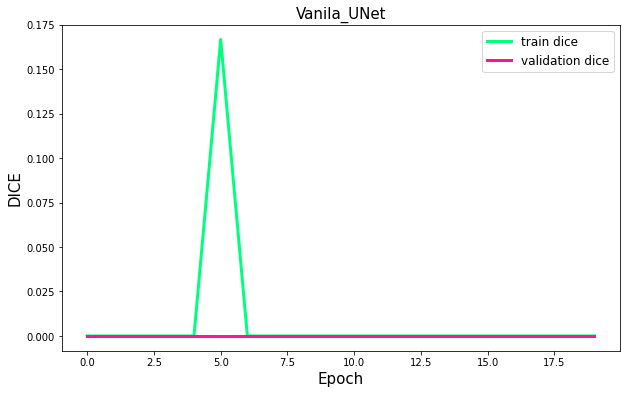

In [ ]:
plot_history(vanilla_unet.model_name, train_history, valid_history, 20)

In [ ]:
iou = compute_iou(vanilla_unet, test_dataloader)
print(f"""{vanilla_unet.model_name}\nMean IoU of the test images - {np.around(iou, 2)*100}%""")

Vanila_UNet
Mean IoU of the test images - 0.0%


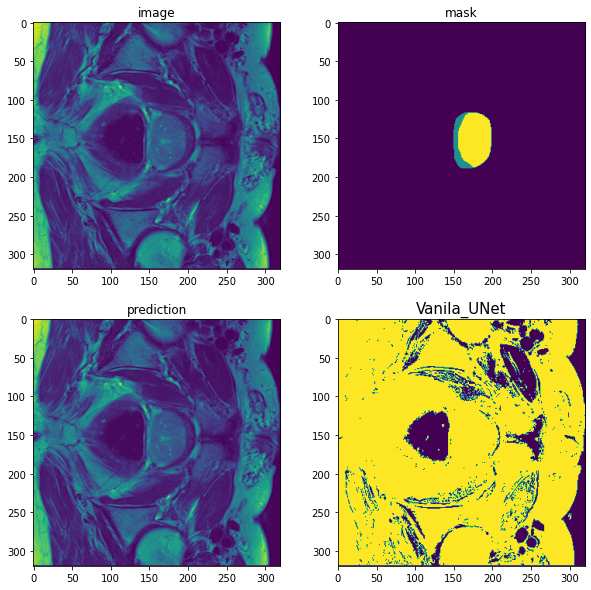

In [ ]:
plot_predictions(vanilla_unet)

In [ ]:
rx50_optimizer = torch.optim.Adam(resnext_unet.parameters(), lr=5e-4)

loss_history, train_history, valid_history = train(resnext_unet, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, False, 15)

Training ResNeX_backbone_tUNet


RuntimeError: ignored

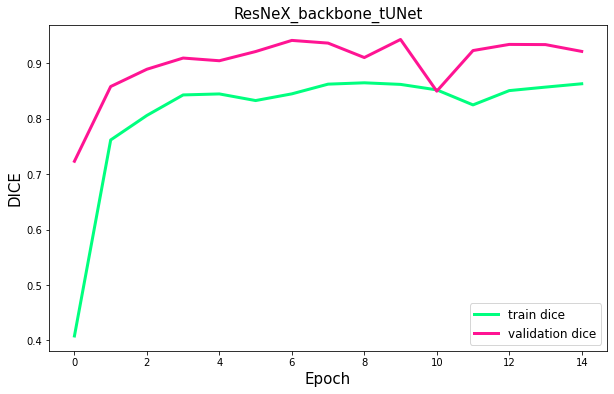

In [ ]:
plot_history(resnext_unet.model_name, train_history, valid_history, 15)

In [ ]:
iou = compute_iou(resnext_unet, test_dataloader)
print(f"""{resnext_unet.model_name}\nMean IoU of the test images - {np.around(iou, 2)*100}%""")

ResNeX_backbone_tUNet
Mean IoU of the test images - 94.0%


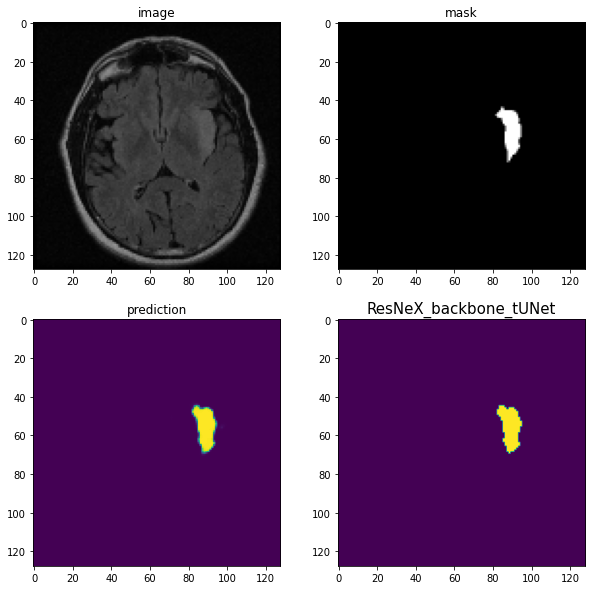

In [ ]:
plot_predictions(resnext_unet)

In [ ]:
fpn_optimizer = torch.optim.Adamax(fpn_unet.parameters(), lr=1e-3)

loss_history, train_history, valid_history = train(fpn_unet, train_dataloader, val_dataloader, bce_dice_loss, fpn_optimizer, False, 20)

Training FPN_UNet
Epoch [0]
Mean train loss: 0.6555078810465056 
Mean train DICE: 0.12 
Mean validation DICE: 1.0
Epoch [1]
Mean train loss: 0.5289654539979529 
Mean train DICE: 0.24 
Mean validation DICE: 0.5
Epoch [2]
Mean train loss: 0.5693492765717383 
Mean train DICE: 0.2 
Mean validation DICE: 0.0
Epoch [3]
Mean train loss: 0.6399086583731696 
Mean train DICE: 0.16 
Mean validation DICE: 0.5
Epoch [4]
Mean train loss: 0.5448417658463586 
Mean train DICE: 0.24 
Mean validation DICE: 1.0
Epoch [5]
Mean train loss: 0.6194905469554942 
Mean train DICE: 0.16 
Mean validation DICE: 0.0
Epoch [6]
Mean train loss: 0.6082935657398775 
Mean train DICE: 0.16 
Mean validation DICE: 0.0
Epoch [7]
Mean train loss: 0.5738560441823211 
Mean train DICE: 0.16 
Mean validation DICE: 1.0
Epoch [8]
Mean train loss: 0.5893888769147452 
Mean train DICE: 0.16 
Mean validation DICE: 0.0
Epoch [9]
Mean train loss: 0.48067765954067 
Mean train DICE: 0.28 
Mean validation DICE: 0.5
Epoch [10]
Mean train los

Exception ignored in: <function ArrayProxy.__del__ at 0x7f3babaacf80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/nibabel/arrayproxy.py", line 170, in __del__
    def __del__(self):
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
plot_history(fpn_unet.model_name,train_history, valid_history, 20)

In [ ]:
iou = compute_iou(fpn_unet, test_dataloader)
print(f"""{fpn_unet.model_name}\nMean IoU of the test images - {np.around(iou, 2)*100}%""")

In [ ]:
plot_predictions(fpn_unet)

In [ ]:
fpn_optimizer2 = torch.optim.Adamax(fpn_eff.parameters(), lr=1e-3)

loss_history, train_history, valid_history = train(fpn_eff, train_dataloader, val_dataloader, bce_dice_loss, fpn_optimizer2, False, 20)

Training FPN_Eff
Epoch [0]
Mean train loss: 1.2394960671663284 
Mean train DICE: 0.25 
Mean validation DICE: 1.0
Epoch [1]
Mean train loss: 1.05612014234066 
Mean train DICE: 0.125 
Mean validation DICE: 0.0020473157415832575
Epoch [2]
Mean train loss: 0.9200798124074936 
Mean train DICE: 0.5454187252977344 
Mean validation DICE: 1.0
Epoch [3]
Mean train loss: 0.9070187136530876 
Mean train DICE: 0.5374572291856906 
Mean validation DICE: 1.0
Epoch [4]
Mean train loss: 0.8452108055353165 
Mean train DICE: 0.21607693268107536 
Mean validation DICE: 0.0
Epoch [5]
Mean train loss: 0.838885709643364 
Mean train DICE: 0.21919937626278987 
Mean validation DICE: 0.05
Epoch [6]
Mean train loss: 0.7802711427211761 
Mean train DICE: 0.4046177550693892 
Mean validation DICE: 0.0
Epoch [7]
Mean train loss: 0.8289923965930939 
Mean train DICE: 0.2275646325033254 
Mean validation DICE: 0.0
Epoch [8]
Mean train loss: 0.8394607231020927 
Mean train DICE: 0.5691822478156743 
Mean validation DICE: 0.0
Ep

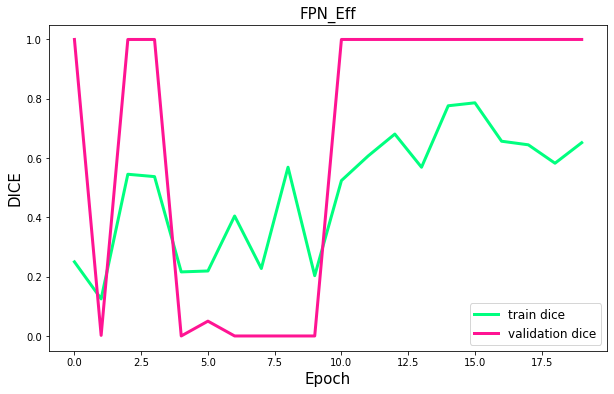

In [ ]:
plot_history(fpn_eff.model_name, train_history, valid_history, 20)

In [ ]:
iou = compute_iou(fpn_eff, test_dataloader)
print(f"""{fpn_eff.model_name}\nMean IoU of the test images - {np.around(iou, 2)*100}%""")

FPN_Eff
Mean IoU of the test images - 33.0%


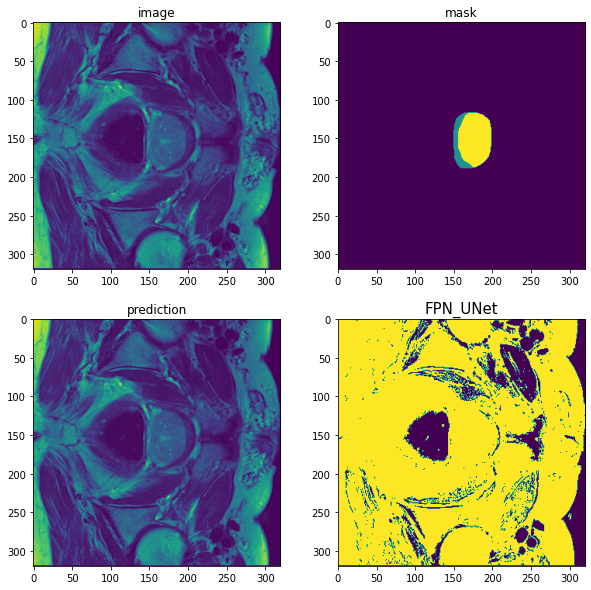

In [ ]:
plot_predictions(fpn_unet)